In this notebook, XGBoost hyperparameters will be tuned on the final feature dataframe. Final model parameters will be chosen based on the one which gives best ROC AUC metric.
First XGBoost base model will be developed on SMOTE and non SMOTE data. Based on the model performance on these two, final hyperparameters will be tuned on either SMOTE or NON SMOTE data.

## Importing libraries, modules and data

In [ ]:
# Importing the required libraries and modules
import os
import zipfile
import numpy as np
import pandas as pd
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve
from tqdm import tqdm

!pip install kds
import kds
from IPython.display import Image

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Importing the train test oot and train_smote dataframes
pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'

#1. X_train dataframe
pickle_in=open(pickle_path+"X_train_final.pickle","rb")
X_train=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_train dataframe is",X_train.shape)

#2. y_train dataframe
pickle_in=open(pickle_path+"y_train_final.pickle","rb")
y_train=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_train dataframe is",y_train.shape)

#3. X_train_smote dataframe
pickle_in=open(pickle_path+"X_train_smote_final.pickle","rb")
X_train_smote=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_train_smote dataframe is",X_train_smote.shape)

#4. y_train_smote dataframe
pickle_in=open(pickle_path+"y_train_smote_final.pickle","rb")
y_train_smote=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_train_smote dataframe is",y_train_smote.shape)

#5. X_test dataframe
pickle_in=open(pickle_path+"X_test_final.pickle","rb")
X_test=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_test dataframe is",X_test.shape)

#6. y_test dataframe
pickle_in=open(pickle_path+"y_test_final.pickle","rb")
y_test=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_test dataframe is",y_test.shape)

#7. X_oot dataframe
pickle_in=open(pickle_path+"X_oot_final.pickle","rb")
X_oot=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_oot dataframe is",X_oot.shape)

#8. y_oot dataframe
pickle_in=open(pickle_path+"y_oot_final.pickle","rb")
y_oot=pickle.load(pickle_in)
pickle_in.close()
print("Shape of y_oot dataframe is",y_oot.shape)

#9. X_test_oot dataframe
pickle_in=open(pickle_path+"X_test_oot_final.pickle","rb")
X_test_oot=pickle.load(pickle_in)
pickle_in.close()
print("Shape of X_test_oot dataframe is",X_test_oot.shape)

Shape of X_train dataframe is (246008, 15)
Shape of y_train dataframe is (246008,)
Shape of X_train_smote dataframe is (452272, 15)
Shape of y_train_smote dataframe is (452272,)
Shape of X_test dataframe is (30751, 15)
Shape of y_test dataframe is (30751,)
Shape of X_oot dataframe is (30752, 15)
Shape of y_oot dataframe is (30752,)
Shape of X_test_oot dataframe is (48744, 15)


## Model Functions

In [ ]:
def PlotConfusionMatrix(y_test,pred_test):
  cf=metrics.confusion_matrix(y_test,pred_test)

  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()]
  group_percentages = ['{0:0.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
  labels=[f'{v1}\n{v2}\n{v3}' for v1,v2,v3 in zip(group_names,group_counts,group_percentages)]
  labels=np.asarray(labels).reshape(2,2)

  fig=plt.figure(figsize=(15,5))
  ax=fig.add_subplot(1,2,1)
  sns.heatmap(cf,cmap='crest',linewidth=0.5,annot=labels,fmt='',ax=ax)
  plt.title('Confusion Matrix')
  plt.ylabel('Real Classes')
  plt.xlabel('Predicted Classes')
  plt.show()

  accuracy = np.trace(cf) / float(np. sum(cf))
  precision = cf[1,1] / sum(cf[:,1])
  recall = cf[1,1]/sum(cf[1,:])
  f1_score = 2*precision*recall / (precision + recall)

  stats_text = "Accuracy={:0.5f}\nPrecision={:0.5f}\nRecall={:0.5f}\nF1 Score={:0.5F}".format(accuracy,precision,recall,f1_score)
  print("----------------Classification Report----------------")
  print(classification_report(y_test,pred_test))
  print("\n",'----------------Accuracy, precision, recall, f1_score----------------')
  print(stats_text)


In [ ]:
def decile_tablel(act,prob,round_decimal=10,change_deciles=10):
  qq=kds.metrics.decile_table(act,prob
                              ,round_decimal=round_decimal
                              ,change_deciles=change_deciles
                              ,labels=False)[['decile',
                                              'prob_min', 'prob_max',
                                              'cnt_cust', 'cnt_resp',
                                              'cnt_non_resp','cum_non_resp',
                                              'cum_resp', 'KS', 'lift']]
  qq["FP"]=round(qq['cnt_non_resp']/qq['cnt_resp'],2)
  qq["FP_cumm"]=round(qq['cum_non_resp']/qq['cnt_resp'],2)
  qq['prob_min']= round(qq['prob_min'], 6)
  qq['frd_cptr%'] = round(qq['cum_resp']/qq.cnt_resp.sum()*100,2)
  qq.columns = ['decile', 'prob_min', 'prob_max', 'ttl_customers', 'bad_customers','gd_customers', 'cum gd_customers',
                'cum_bad_customers', 'KS', 'Lift', 'FP', 'cum FP', 'default_captr%']
  return qq

In [ ]:
def ROC_curve_combined(actl_train,pred_train,actl_test,pred_test,actl_oot,pred_oot):
  print('Ploting the ROC Curve')
  fpr_train, tpr_train, thresholds =metrics.roc_curve(actl_train, pred_train)
  roc_auc_train = metrics.auc(fpr_train, tpr_train)*100 # compute area under the curve

  fpr_test, tpr_test, thresholds =metrics.roc_curve(actl_test, pred_test)
  roc_auc_test = metrics.auc(fpr_test, tpr_test)*100 # compute area under the curve

  fpr_oot, tpr_oot, thresholds =metrics.roc_curve(actl_oot, pred_oot)
  roc_auc_oot = metrics.auc(fpr_oot, tpr_oot)*100 # compute area under the curve

  plt.figure()
  plt.plot(fpr_train, tpr_train, label='Train ROC curve (area=%0.2f%%)' % (roc_auc_train))
  plt.plot(fpr_test, tpr_test, label='Test ROC curve (area=%0.2f%%)' % (roc_auc_test))
  plt.plot(fpr_oot, tpr_oot, label='OOT ROC curve (area=%0.2f%%)' % (roc_auc_oot))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Bate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc= "lower right")
  plt.show()

## XGBoost base model on SMOTE data

In [ ]:
# Lets fit the model
xgb_clf = XGBClassifier(random_state=0).fit(X_train_smote, y_train_smote)

In [ ]:
# predict the probabilities
xgb_clf_proba_train_smote=xgb_clf.predict_proba(X_train_smote)
xgb_clf_proba_train=xgb_clf.predict_proba(X_train)
xgb_clf_proba_test=xgb_clf.predict_proba(X_test)
xgb_clf_proba_oot=xgb_clf.predict_proba(X_oot)

In [ ]:
### AUC estimation
# train SMOTE
fpr, tpr, threshold = metrics.roc_curve(y_train_smote,xgb_clf_proba_train_smote[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train SMOTE AUC is ",roc_auc)

# train
fpr, tpr, threshold = metrics.roc_curve(y_train,xgb_clf_proba_train[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train AUC is ",roc_auc)

# test
fpr, tpr, threshold = metrics.roc_curve(y_test,xgb_clf_proba_test[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Test AUC is ",roc_auc)

# oot
fpr, tpr, threshold = metrics.roc_curve(y_oot,xgb_clf_proba_oot[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("OOT AUC is ",roc_auc)

Train SMOTE AUC is  0.9682960144548584
Train AUC is  0.745541186459225
Test AUC is  0.6993599495655513
OOT AUC is  0.6943304645347336


## XGBoost base model on NON SMOTE data

In [ ]:
# Lets fit the model
xgb_clf = XGBClassifier(random_state=0).fit(X_train, y_train)

In [ ]:
# predict the probabilities
xgb_clf_proba_train_smote=xgb_clf.predict_proba(X_train_smote)
xgb_clf_proba_train=xgb_clf.predict_proba(X_train)
xgb_clf_proba_test=xgb_clf.predict_proba(X_test)
xgb_clf_proba_oot=xgb_clf.predict_proba(X_oot)

In [ ]:
### AUC estimation
# train SMOTE
fpr, tpr, threshold = metrics.roc_curve(y_train_smote,xgb_clf_proba_train_smote[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train SMOTE AUC is ",roc_auc)

# train
fpr, tpr, threshold = metrics.roc_curve(y_train,xgb_clf_proba_train[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train AUC is ",roc_auc)

# test
fpr, tpr, threshold = metrics.roc_curve(y_test,xgb_clf_proba_test[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Test AUC is ",roc_auc)

# oot
fpr, tpr, threshold = metrics.roc_curve(y_oot,xgb_clf_proba_oot[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("OOT AUC is ",roc_auc)

Train SMOTE AUC is  0.8000727019778237
Train AUC is  0.8416285223190829
Test AUC is  0.7486916000879766
OOT AUC is  0.7459255653131678


### Observations:
As XGBoost model ROC AUC metric for SMOTE data shown a high ROC AUC for SMOTE train data while it shown high ROC AUC for oot non smote data. Lets select the hyperparamets based on SMOTE and NON SMOTE data both.

## Hyperparameter tuning of XGBoost model on SMOTE data:

In [ ]:
n_estimators=[10,20,50,100]
learning_rate=[0.05,0.1,0.5,1]
depth=[2,4,6,8,10]
gamm=[0]
reg_alp=[1]
reg_lambda=[1,5]

cv_dataframe_xgb=pd.DataFrame(columns=['n_estimators','learning_rate','depth','min_loss','L1_reg','L2_reg',
                                       'Train_SMOTE_F1Score','Train_SMOTE_AUC',
                                       'Train_F1Score','Train_AUC',
                                       'Test_F1Score','TEST_AUC',
                                       'OOT_F1Score','OOT_AUC'])

for n_est in tqdm(n_estimators):
  for lrnr in learning_rate:
    for dpt in depth:
      for gm in gamm:
        for reg_al in reg_alp:
          for reg_lamb in reg_lambda:
            df_lst=[n_est,lrnr,dpt,gm,reg_al,reg_lamb]
            print('Evaluating for ',df_lst)
            xgb_clf = XGBClassifier(n_estimators=n_est,learning_rate=lrnr,max_depth=dpt,gamma=gm,reg_alpha=reg_al,reg_lambda=reg_lamb,random_state=0)
            xgb_clf.fit(X_train_smote, y_train_smote)

            # predict the target classes and probabilities
            xgb_clf_predict_train_smote=xgb_clf.predict(X_train_smote)
            xgb_clf_predict_train=xgb_clf.predict(X_train)
            xgb_clf_predict_test=xgb_clf.predict(X_test)
            xgb_clf_predict_oot=xgb_clf.predict(X_oot)

            xgb_clf_proba_train_smote=xgb_clf.predict_proba(X_train_smote)
            xgb_clf_proba_train=xgb_clf.predict_proba(X_train)
            xgb_clf_proba_test=xgb_clf.predict_proba(X_test)
            xgb_clf_proba_oot=xgb_clf.predict_proba(X_oot)

            ### AUC estimation
            # train SMOTE
            f1_sc=f1_score(y_train_smote,xgb_clf_predict_train_smote,average="macro")
            fpr, tpr, threshold = metrics.roc_curve(y_train_smote,xgb_clf_proba_train_smote[:,1])
            roc_auc=metrics.auc(fpr,tpr)
            df_lst.append(f1_sc)
            df_lst.append(roc_auc)

            # train
            f1_sc=f1_score(y_train,xgb_clf_predict_train,average="macro")
            fpr, tpr, threshold = metrics.roc_curve(y_train,xgb_clf_proba_train[:,1])
            roc_auc=metrics.auc(fpr,tpr)
            df_lst.append(f1_sc)
            df_lst.append(roc_auc)

            # test
            f1_sc=f1_score(y_test,xgb_clf_predict_test,average="macro")
            fpr, tpr, threshold = metrics.roc_curve(y_test,xgb_clf_proba_test[:,1])
            roc_auc=metrics.auc(fpr,tpr)
            df_lst.append(f1_sc)
            df_lst.append(roc_auc)

            # oot
            f1_sc=f1_score(y_oot,xgb_clf_predict_oot,average="macro")
            fpr, tpr, threshold = metrics.roc_curve(y_oot,xgb_clf_proba_oot[:,1])
            roc_auc=metrics.auc(fpr,tpr)
            df_lst.append(f1_sc)
            df_lst.append(roc_auc)

            # Lets store in final dataframe
            cv_dataframe_xgb.loc[len(cv_dataframe_xgb)]=df_lst

    # Lets store the dataframes for analysis
    pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'
    pickle_out=open(pickle_path+'cv_dataframe_xgb.pickle', 'wb')
    pickle.dump(cv_dataframe_xgb,pickle_out)
    pickle_out.close()
    cv_dataframe_xgb.to_csv('/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/cv_dataframe_xgb.csv',index=False)

  0%|          | 0/4 [00:00<?, ?it/s]

Evaluating for  [10, 0.05, 2, 0, 1, 1]
Evaluating for  [10, 0.05, 2, 0, 1, 5]
Evaluating for  [10, 0.05, 4, 0, 1, 1]
Evaluating for  [10, 0.05, 4, 0, 1, 5]
Evaluating for  [10, 0.05, 6, 0, 1, 1]
Evaluating for  [10, 0.05, 6, 0, 1, 5]
Evaluating for  [10, 0.05, 8, 0, 1, 1]
Evaluating for  [10, 0.05, 8, 0, 1, 5]
Evaluating for  [10, 0.05, 10, 0, 1, 1]
Evaluating for  [10, 0.05, 10, 0, 1, 5]
Evaluating for  [10, 0.1, 2, 0, 1, 1]
Evaluating for  [10, 0.1, 2, 0, 1, 5]
Evaluating for  [10, 0.1, 4, 0, 1, 1]
Evaluating for  [10, 0.1, 4, 0, 1, 5]
Evaluating for  [10, 0.1, 6, 0, 1, 1]
Evaluating for  [10, 0.1, 6, 0, 1, 5]
Evaluating for  [10, 0.1, 8, 0, 1, 1]
Evaluating for  [10, 0.1, 8, 0, 1, 5]
Evaluating for  [10, 0.1, 10, 0, 1, 1]
Evaluating for  [10, 0.1, 10, 0, 1, 5]
Evaluating for  [10, 0.5, 2, 0, 1, 1]
Evaluating for  [10, 0.5, 2, 0, 1, 5]
Evaluating for  [10, 0.5, 4, 0, 1, 1]
Evaluating for  [10, 0.5, 4, 0, 1, 5]
Evaluating for  [10, 0.5, 6, 0, 1, 1]
Evaluating for  [10, 0.5, 6, 0, 1, 5

 25%|██▌       | 1/4 [02:03<06:10, 123.61s/it]

Evaluating for  [20, 0.05, 2, 0, 1, 1]
Evaluating for  [20, 0.05, 2, 0, 1, 5]
Evaluating for  [20, 0.05, 4, 0, 1, 1]
Evaluating for  [20, 0.05, 4, 0, 1, 5]
Evaluating for  [20, 0.05, 6, 0, 1, 1]
Evaluating for  [20, 0.05, 6, 0, 1, 5]
Evaluating for  [20, 0.05, 8, 0, 1, 1]
Evaluating for  [20, 0.05, 8, 0, 1, 5]
Evaluating for  [20, 0.05, 10, 0, 1, 1]
Evaluating for  [20, 0.05, 10, 0, 1, 5]
Evaluating for  [20, 0.1, 2, 0, 1, 1]
Evaluating for  [20, 0.1, 2, 0, 1, 5]
Evaluating for  [20, 0.1, 4, 0, 1, 1]
Evaluating for  [20, 0.1, 4, 0, 1, 5]
Evaluating for  [20, 0.1, 6, 0, 1, 1]
Evaluating for  [20, 0.1, 6, 0, 1, 5]
Evaluating for  [20, 0.1, 8, 0, 1, 1]
Evaluating for  [20, 0.1, 8, 0, 1, 5]
Evaluating for  [20, 0.1, 10, 0, 1, 1]
Evaluating for  [20, 0.1, 10, 0, 1, 5]
Evaluating for  [20, 0.5, 2, 0, 1, 1]
Evaluating for  [20, 0.5, 2, 0, 1, 5]
Evaluating for  [20, 0.5, 4, 0, 1, 1]
Evaluating for  [20, 0.5, 4, 0, 1, 5]
Evaluating for  [20, 0.5, 6, 0, 1, 1]
Evaluating for  [20, 0.5, 6, 0, 1, 5

 50%|█████     | 2/4 [04:42<04:48, 144.33s/it]

Evaluating for  [50, 0.05, 2, 0, 1, 1]
Evaluating for  [50, 0.05, 2, 0, 1, 5]
Evaluating for  [50, 0.05, 4, 0, 1, 1]
Evaluating for  [50, 0.05, 4, 0, 1, 5]
Evaluating for  [50, 0.05, 6, 0, 1, 1]
Evaluating for  [50, 0.05, 6, 0, 1, 5]
Evaluating for  [50, 0.05, 8, 0, 1, 1]
Evaluating for  [50, 0.05, 8, 0, 1, 5]
Evaluating for  [50, 0.05, 10, 0, 1, 1]
Evaluating for  [50, 0.05, 10, 0, 1, 5]
Evaluating for  [50, 0.1, 2, 0, 1, 1]
Evaluating for  [50, 0.1, 2, 0, 1, 5]
Evaluating for  [50, 0.1, 4, 0, 1, 1]
Evaluating for  [50, 0.1, 4, 0, 1, 5]
Evaluating for  [50, 0.1, 6, 0, 1, 1]
Evaluating for  [50, 0.1, 6, 0, 1, 5]
Evaluating for  [50, 0.1, 8, 0, 1, 1]
Evaluating for  [50, 0.1, 8, 0, 1, 5]
Evaluating for  [50, 0.1, 10, 0, 1, 1]
Evaluating for  [50, 0.1, 10, 0, 1, 5]
Evaluating for  [50, 0.5, 2, 0, 1, 1]
Evaluating for  [50, 0.5, 2, 0, 1, 5]
Evaluating for  [50, 0.5, 4, 0, 1, 1]
Evaluating for  [50, 0.5, 4, 0, 1, 5]
Evaluating for  [50, 0.5, 6, 0, 1, 1]
Evaluating for  [50, 0.5, 6, 0, 1, 5

 75%|███████▌  | 3/4 [09:23<03:26, 206.96s/it]

Evaluating for  [100, 0.05, 2, 0, 1, 1]
Evaluating for  [100, 0.05, 2, 0, 1, 5]
Evaluating for  [100, 0.05, 4, 0, 1, 1]
Evaluating for  [100, 0.05, 4, 0, 1, 5]
Evaluating for  [100, 0.05, 6, 0, 1, 1]
Evaluating for  [100, 0.05, 6, 0, 1, 5]
Evaluating for  [100, 0.05, 8, 0, 1, 1]
Evaluating for  [100, 0.05, 8, 0, 1, 5]
Evaluating for  [100, 0.05, 10, 0, 1, 1]
Evaluating for  [100, 0.05, 10, 0, 1, 5]
Evaluating for  [100, 0.1, 2, 0, 1, 1]
Evaluating for  [100, 0.1, 2, 0, 1, 5]
Evaluating for  [100, 0.1, 4, 0, 1, 1]
Evaluating for  [100, 0.1, 4, 0, 1, 5]
Evaluating for  [100, 0.1, 6, 0, 1, 1]
Evaluating for  [100, 0.1, 6, 0, 1, 5]
Evaluating for  [100, 0.1, 8, 0, 1, 1]
Evaluating for  [100, 0.1, 8, 0, 1, 5]
Evaluating for  [100, 0.1, 10, 0, 1, 1]
Evaluating for  [100, 0.1, 10, 0, 1, 5]
Evaluating for  [100, 0.5, 2, 0, 1, 1]
Evaluating for  [100, 0.5, 2, 0, 1, 5]
Evaluating for  [100, 0.5, 4, 0, 1, 1]
Evaluating for  [100, 0.5, 4, 0, 1, 5]
Evaluating for  [100, 0.5, 6, 0, 1, 1]
Evaluating 

100%|██████████| 4/4 [17:13<00:00, 258.26s/it]


In [ ]:
# Lets load the dataframe and select the best hyperparameters
cv_dataframe_xgb=pd.read_csv('/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/cv_dataframe_xgb.csv')

In [ ]:
cv_dataframe_xgb

,n_estimators,learning_rate,depth,min_loss,L1_reg,L2_reg,Train_SMOTE_F1Score,Train_SMOTE_AUC,Train_F1Score,Train_AUC,Test_F1Score,TEST_AUC,OOT_F1Score,OOT_AUC
0,10.0,0.05,2.0,0.0,1.0,1.0,0.672028,0.739368,0.475061,0.669564,0.475528,0.671524,0.470248,0.664479
1,10.0,0.05,2.0,0.0,1.0,5.0,0.672028,0.739368,0.475061,0.669564,0.475528,0.671524,0.470248,0.664479
2,10.0,0.05,4.0,0.0,1.0,1.0,0.701002,0.784461,0.508420,0.689934,0.509013,0.689940,0.503936,0.684416
3,10.0,0.05,4.0,0.0,1.0,5.0,0.701037,0.784445,0.508473,0.689929,0.509034,0.689900,0.503999,0.684511
4,10.0,0.05,6.0,0.0,1.0,1.0,0.756900,0.836423,0.544098,0.695956,0.547041,0.696137,0.538555,0.685327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,100.0,1.00,6.0,0.0,1.0,5.0,0.931309,0.977350,0.620912,0.803632,0.559455,0.680111,0.555903,0.681093
156,100.0,1.00,8.0,0.0,1.0,1.0,0.961241,0.992871,0.783772,0.935161,0.557266,0.668732,0.553481,0.662039
157,100.0,1.00,8.0,0.0,1.0,5.0,0.956354,0.991011,0.746901,0.916633,0.555299,0.665728,0.551076,0.666174
158,100.0,1.00,10.0,0.0,1.0,1.0,0.993294,0.999743,0.962703,0.997425,0.556311,0.659903,0.555656,0.661273


## Hyperparameter tuning of XGBoost model on NON SMOTE data:

In [ ]:
n_estimators=[10,20,50,100]
learning_rate=[0.05,0.1,0.5,1]
depth=[2,4,6,8,10]
gamm=[0]
reg_alp=[1]
reg_lambda=[1,5]

cv_dataframe_xgb=pd.DataFrame(columns=['n_estimators','learning_rate','depth','min_loss','L1_reg','L2_reg',
                                       'Train_SMOTE_F1Score','Train_SMOTE_AUC',
                                       'Train_F1Score','Train_AUC',
                                       'Test_F1Score','TEST_AUC',
                                       'OOT_F1Score','OOT_AUC'])

for n_est in tqdm(n_estimators):
  for lrnr in learning_rate:
    for dpt in depth:
      for gm in gamm:
        for reg_al in reg_alp:
          for reg_lamb in reg_lambda:
            df_lst=[n_est,lrnr,dpt,gm,reg_al,reg_lamb]
            print('Evaluating for ',df_lst)
            xgb_clf = XGBClassifier(n_estimators=n_est,learning_rate=lrnr,max_depth=dpt,gamma=gm,reg_alpha=reg_al,reg_lambda=reg_lamb,random_state=0)
            xgb_clf.fit(X_train, y_train)

            # predict the target classes and probabilities
            xgb_clf_predict_train_smote=xgb_clf.predict(X_train_smote)
            xgb_clf_predict_train=xgb_clf.predict(X_train)
            xgb_clf_predict_test=xgb_clf.predict(X_test)
            xgb_clf_predict_oot=xgb_clf.predict(X_oot)

            xgb_clf_proba_train_smote=xgb_clf.predict_proba(X_train_smote)
            xgb_clf_proba_train=xgb_clf.predict_proba(X_train)
            xgb_clf_proba_test=xgb_clf.predict_proba(X_test)
            xgb_clf_proba_oot=xgb_clf.predict_proba(X_oot)

            ### AUC estimation
            # train SMOTE
            f1_sc=f1_score(y_train_smote,xgb_clf_predict_train_smote,average="macro")
            fpr, tpr, threshold = metrics.roc_curve(y_train_smote,xgb_clf_proba_train_smote[:,1])
            roc_auc=metrics.auc(fpr,tpr)
            df_lst.append(f1_sc)
            df_lst.append(roc_auc)

            # train
            f1_sc=f1_score(y_train,xgb_clf_predict_train,average="macro")
            fpr, tpr, threshold = metrics.roc_curve(y_train,xgb_clf_proba_train[:,1])
            roc_auc=metrics.auc(fpr,tpr)
            df_lst.append(f1_sc)
            df_lst.append(roc_auc)

            # test
            f1_sc=f1_score(y_test,xgb_clf_predict_test,average="macro")
            fpr, tpr, threshold = metrics.roc_curve(y_test,xgb_clf_proba_test[:,1])
            roc_auc=metrics.auc(fpr,tpr)
            df_lst.append(f1_sc)
            df_lst.append(roc_auc)

            # oot
            f1_sc=f1_score(y_oot,xgb_clf_predict_oot,average="macro")
            fpr, tpr, threshold = metrics.roc_curve(y_oot,xgb_clf_proba_oot[:,1])
            roc_auc=metrics.auc(fpr,tpr)
            df_lst.append(f1_sc)
            df_lst.append(roc_auc)

            # Lets store in final dataframe
            cv_dataframe_xgb.loc[len(cv_dataframe_xgb)]=df_lst

    # Lets store the dataframes for analysis
    pickle_path = '/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/'
    pickle_out=open(pickle_path+'cv_dataframe_xgb_woSmote.pickle', 'wb')
    pickle.dump(cv_dataframe_xgb,pickle_out)
    pickle_out.close()
    cv_dataframe_xgb.to_csv('/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/cv_dataframe_xgb_woSmote.csv',index=False)

  0%|          | 0/4 [00:00<?, ?it/s]

Evaluating for  [10, 0.05, 2, 0, 1, 1]
Evaluating for  [10, 0.05, 2, 0, 1, 5]
Evaluating for  [10, 0.05, 4, 0, 1, 1]
Evaluating for  [10, 0.05, 4, 0, 1, 5]
Evaluating for  [10, 0.05, 6, 0, 1, 1]
Evaluating for  [10, 0.05, 6, 0, 1, 5]
Evaluating for  [10, 0.05, 8, 0, 1, 1]
Evaluating for  [10, 0.05, 8, 0, 1, 5]
Evaluating for  [10, 0.05, 10, 0, 1, 1]
Evaluating for  [10, 0.05, 10, 0, 1, 5]
Evaluating for  [10, 0.1, 2, 0, 1, 1]
Evaluating for  [10, 0.1, 2, 0, 1, 5]
Evaluating for  [10, 0.1, 4, 0, 1, 1]
Evaluating for  [10, 0.1, 4, 0, 1, 5]
Evaluating for  [10, 0.1, 6, 0, 1, 1]
Evaluating for  [10, 0.1, 6, 0, 1, 5]
Evaluating for  [10, 0.1, 8, 0, 1, 1]
Evaluating for  [10, 0.1, 8, 0, 1, 5]
Evaluating for  [10, 0.1, 10, 0, 1, 1]
Evaluating for  [10, 0.1, 10, 0, 1, 5]
Evaluating for  [10, 0.5, 2, 0, 1, 1]
Evaluating for  [10, 0.5, 2, 0, 1, 5]
Evaluating for  [10, 0.5, 4, 0, 1, 1]
Evaluating for  [10, 0.5, 4, 0, 1, 5]
Evaluating for  [10, 0.5, 6, 0, 1, 1]
Evaluating for  [10, 0.5, 6, 0, 1, 5

 25%|██▌       | 1/4 [01:30<04:32, 90.81s/it]

Evaluating for  [20, 0.05, 2, 0, 1, 1]
Evaluating for  [20, 0.05, 2, 0, 1, 5]
Evaluating for  [20, 0.05, 4, 0, 1, 1]
Evaluating for  [20, 0.05, 4, 0, 1, 5]
Evaluating for  [20, 0.05, 6, 0, 1, 1]
Evaluating for  [20, 0.05, 6, 0, 1, 5]
Evaluating for  [20, 0.05, 8, 0, 1, 1]
Evaluating for  [20, 0.05, 8, 0, 1, 5]
Evaluating for  [20, 0.05, 10, 0, 1, 1]
Evaluating for  [20, 0.05, 10, 0, 1, 5]
Evaluating for  [20, 0.1, 2, 0, 1, 1]
Evaluating for  [20, 0.1, 2, 0, 1, 5]
Evaluating for  [20, 0.1, 4, 0, 1, 1]
Evaluating for  [20, 0.1, 4, 0, 1, 5]
Evaluating for  [20, 0.1, 6, 0, 1, 1]
Evaluating for  [20, 0.1, 6, 0, 1, 5]
Evaluating for  [20, 0.1, 8, 0, 1, 1]
Evaluating for  [20, 0.1, 8, 0, 1, 5]
Evaluating for  [20, 0.1, 10, 0, 1, 1]
Evaluating for  [20, 0.1, 10, 0, 1, 5]
Evaluating for  [20, 0.5, 2, 0, 1, 1]
Evaluating for  [20, 0.5, 2, 0, 1, 5]
Evaluating for  [20, 0.5, 4, 0, 1, 1]
Evaluating for  [20, 0.5, 4, 0, 1, 5]
Evaluating for  [20, 0.5, 6, 0, 1, 1]
Evaluating for  [20, 0.5, 6, 0, 1, 5

 50%|█████     | 2/4 [03:27<03:32, 106.11s/it]

Evaluating for  [50, 0.05, 2, 0, 1, 1]
Evaluating for  [50, 0.05, 2, 0, 1, 5]
Evaluating for  [50, 0.05, 4, 0, 1, 1]
Evaluating for  [50, 0.05, 4, 0, 1, 5]
Evaluating for  [50, 0.05, 6, 0, 1, 1]
Evaluating for  [50, 0.05, 6, 0, 1, 5]
Evaluating for  [50, 0.05, 8, 0, 1, 1]
Evaluating for  [50, 0.05, 8, 0, 1, 5]
Evaluating for  [50, 0.05, 10, 0, 1, 1]
Evaluating for  [50, 0.05, 10, 0, 1, 5]
Evaluating for  [50, 0.1, 2, 0, 1, 1]
Evaluating for  [50, 0.1, 2, 0, 1, 5]
Evaluating for  [50, 0.1, 4, 0, 1, 1]
Evaluating for  [50, 0.1, 4, 0, 1, 5]
Evaluating for  [50, 0.1, 6, 0, 1, 1]
Evaluating for  [50, 0.1, 6, 0, 1, 5]
Evaluating for  [50, 0.1, 8, 0, 1, 1]
Evaluating for  [50, 0.1, 8, 0, 1, 5]
Evaluating for  [50, 0.1, 10, 0, 1, 1]
Evaluating for  [50, 0.1, 10, 0, 1, 5]
Evaluating for  [50, 0.5, 2, 0, 1, 1]
Evaluating for  [50, 0.5, 2, 0, 1, 5]
Evaluating for  [50, 0.5, 4, 0, 1, 1]
Evaluating for  [50, 0.5, 4, 0, 1, 5]
Evaluating for  [50, 0.5, 6, 0, 1, 1]
Evaluating for  [50, 0.5, 6, 0, 1, 5

 75%|███████▌  | 3/4 [06:53<02:31, 151.84s/it]

Evaluating for  [100, 0.05, 2, 0, 1, 1]
Evaluating for  [100, 0.05, 2, 0, 1, 5]
Evaluating for  [100, 0.05, 4, 0, 1, 1]
Evaluating for  [100, 0.05, 4, 0, 1, 5]
Evaluating for  [100, 0.05, 6, 0, 1, 1]
Evaluating for  [100, 0.05, 6, 0, 1, 5]
Evaluating for  [100, 0.05, 8, 0, 1, 1]
Evaluating for  [100, 0.05, 8, 0, 1, 5]
Evaluating for  [100, 0.05, 10, 0, 1, 1]
Evaluating for  [100, 0.05, 10, 0, 1, 5]
Evaluating for  [100, 0.1, 2, 0, 1, 1]
Evaluating for  [100, 0.1, 2, 0, 1, 5]
Evaluating for  [100, 0.1, 4, 0, 1, 1]
Evaluating for  [100, 0.1, 4, 0, 1, 5]
Evaluating for  [100, 0.1, 6, 0, 1, 1]
Evaluating for  [100, 0.1, 6, 0, 1, 5]
Evaluating for  [100, 0.1, 8, 0, 1, 1]
Evaluating for  [100, 0.1, 8, 0, 1, 5]
Evaluating for  [100, 0.1, 10, 0, 1, 1]
Evaluating for  [100, 0.1, 10, 0, 1, 5]
Evaluating for  [100, 0.5, 2, 0, 1, 1]
Evaluating for  [100, 0.5, 2, 0, 1, 5]
Evaluating for  [100, 0.5, 4, 0, 1, 1]
Evaluating for  [100, 0.5, 4, 0, 1, 5]
Evaluating for  [100, 0.5, 6, 0, 1, 1]
Evaluating 

100%|██████████| 4/4 [12:42<00:00, 190.66s/it]


In [ ]:
# Lets load the dataframe and select the best hyperparameters
cv_dataframe_xgb_woSmote=pd.read_csv('/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/cv_dataframe_xgb_woSmote.csv')

In [ ]:
cv_dataframe_xgb_woSmote

,n_estimators,learning_rate,depth,min_loss,L1_reg,L2_reg,Train_SMOTE_F1Score,Train_SMOTE_AUC,Train_F1Score,Train_AUC,Test_F1Score,TEST_AUC,OOT_F1Score,OOT_AUC
0,10.0,0.05,2.0,0.0,1.0,1.0,0.333333,0.685347,0.478956,0.681889,0.478558,0.680922,0.479485,0.675199
1,10.0,0.05,2.0,0.0,1.0,5.0,0.333333,0.685425,0.478956,0.684311,0.478558,0.683317,0.479485,0.678341
2,10.0,0.05,4.0,0.0,1.0,1.0,0.333333,0.723222,0.478956,0.716971,0.478558,0.712281,0.479485,0.709475
3,10.0,0.05,4.0,0.0,1.0,5.0,0.333333,0.722651,0.478956,0.716756,0.478558,0.712366,0.479485,0.709232
4,10.0,0.05,6.0,0.0,1.0,1.0,0.333333,0.740924,0.478956,0.736546,0.478558,0.724358,0.479485,0.723479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,100.0,1.00,6.0,0.0,1.0,5.0,0.429179,0.798041,0.630240,0.888700,0.531302,0.705921,0.532623,0.701457
156,100.0,1.00,8.0,0.0,1.0,1.0,0.526862,0.839440,0.859964,0.982174,0.542817,0.684477,0.541848,0.675794
157,100.0,1.00,8.0,0.0,1.0,5.0,0.508495,0.838040,0.817328,0.973743,0.541197,0.686221,0.543913,0.679627
158,100.0,1.00,10.0,0.0,1.0,1.0,0.593482,0.869565,0.998436,0.999999,0.542999,0.671333,0.538960,0.671372


### Observations:
1. XGBoost model on train non SMOTE data has shown lesser bias and variance as compared to SMOTE data.
2. Following hyperparameters selected for logistic regression:

  a. n_estimators=100,

  b. learning_rate=0.5,

  c. max_depth=2,

  d. gamma=0,

  e. reg_alpha=1,
  
  f. reg_lambda=1

These values are selected based on the bias variance tradeoff.

## XGBoost final model:
Lets asses the performance of the XGBoost hyperparameter tuned model.


In [ ]:
# Lets fit the model
xgb_clf = XGBClassifier(n_estimators=100,learning_rate=0.5,max_depth=2,gamma=0,reg_alpha=1,reg_lambda=1,random_state=0)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [ ]:
# predict the target classes and probabilities
xgb_clf_predict_train_smote=xgb_clf.predict(X_train_smote)
xgb_clf_predict_train=xgb_clf.predict(X_train)
xgb_clf_predict_test=xgb_clf.predict(X_test)
xgb_clf_predict_oot=xgb_clf.predict(X_oot)

xgb_clf_proba_train_smote=xgb_clf.predict_proba(X_train_smote)
xgb_clf_proba_train=xgb_clf.predict_proba(X_train)
xgb_clf_proba_test=xgb_clf.predict_proba(X_test)
xgb_clf_proba_oot=xgb_clf.predict_proba(X_oot)

### ROC AUC

In [ ]:
### AUC estimation
# train SMOTE
fpr, tpr, threshold = metrics.roc_curve(y_train_smote,xgb_clf_proba_train_smote[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train SMOTE AUC is ",roc_auc)

# train
fpr, tpr, threshold = metrics.roc_curve(y_train,xgb_clf_proba_train[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train AUC is ",roc_auc)

# test
fpr, tpr, threshold = metrics.roc_curve(y_test,xgb_clf_proba_test[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Test AUC is ",roc_auc)

# oot
fpr, tpr, threshold = metrics.roc_curve(y_oot,xgb_clf_proba_oot[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("OOT AUC is ",roc_auc)

Train SMOTE AUC is  0.7685491164564322
Train AUC is  0.7646118044320457
Test AUC is  0.7580705864274045
OOT AUC is  0.757305888912811


Ploting the ROC Curve


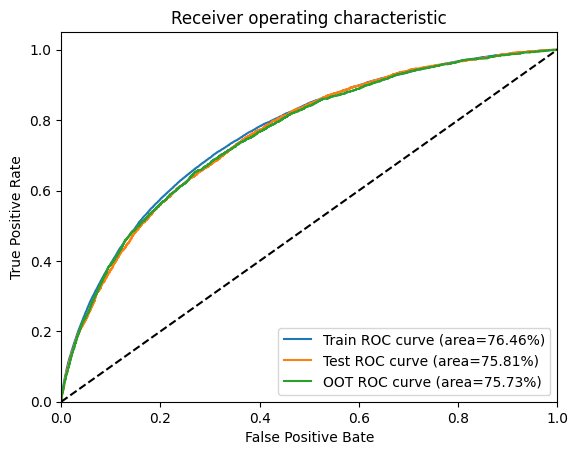

In [ ]:
ROC_curve_combined(y_train,xgb_clf_proba_train[:,1],y_test,xgb_clf_proba_test[:,1],y_oot,xgb_clf_proba_oot[:,1])

### Feature importance:

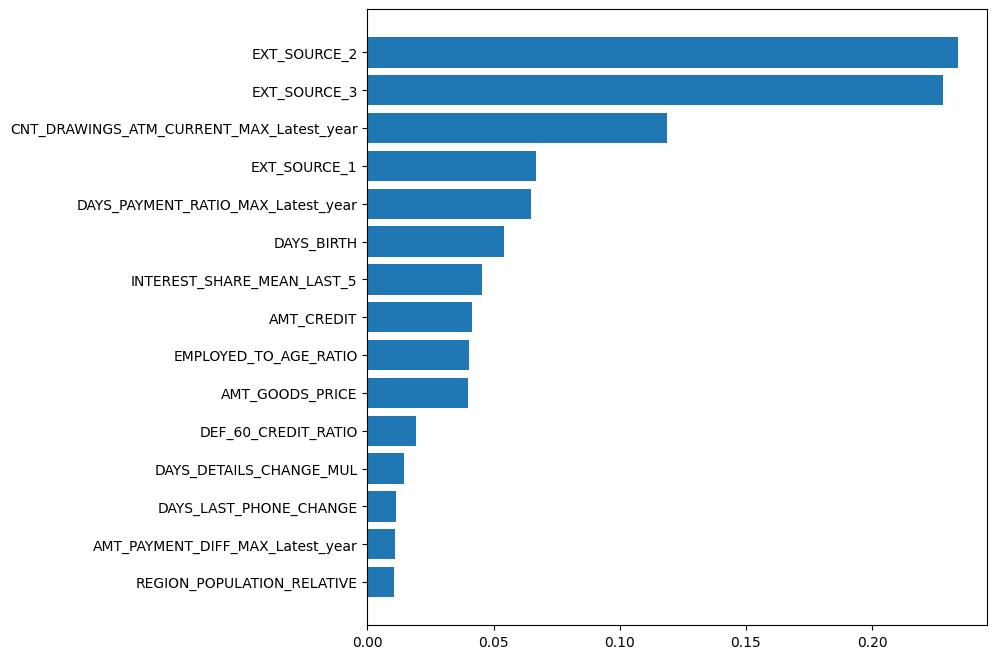

In [ ]:
# model feature importance
plt.figure(figsize=(8,8))

sorted_idx=xgb_clf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx],xgb_clf.feature_importances_[sorted_idx])
plt.show()

In [ ]:
# Lets use the first ten important features to build the model and check the performance
print('First ten important features are ')
top_10_features=list(X_train.columns[sorted_idx])[::-1][0:10]
top_10_features

First ten important features are 


['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CNT_DRAWINGS_ATM_CURRENT_MAX_Latest_year',
 'EXT_SOURCE_1',
 'DAYS_PAYMENT_RATIO_MAX_Latest_year',
 'DAYS_BIRTH',
 'INTEREST_SHARE_MEAN_LAST_5',
 'AMT_CREDIT',
 'EMPLOYED_TO_AGE_RATIO',
 'AMT_GOODS_PRICE']

In [ ]:
# Lets update the dataframes with top 10 features
#1. X_train dataframe
X_train=X_train[top_10_features]
print("Shape of X_train dataframe is",X_train.shape)

#2. y_train dataframe
print("Shape of y_train dataframe is",y_train.shape)

#3. X_train_smote dataframe
X_train_smote=X_train_smote[top_10_features]
print("Shape of X_train_smote dataframe is",X_train_smote.shape)

#4. y_train_smote dataframe
print("Shape of y_train_smote dataframe is",y_train_smote.shape)

#5. X_test dataframe
X_test=X_test[top_10_features]
print("Shape of X_test dataframe is",X_test.shape)

#6. y_test dataframe
print("Shape of y_test dataframe is",y_test.shape)

#7. X_oot dataframe
X_oot=X_oot[top_10_features]
print("Shape of X_oot dataframe is",X_oot.shape)

#8. y_oot dataframe
print("Shape of y_oot dataframe is",y_oot.shape)

#9. X_test_oot dataframe
X_test_oot=X_test_oot[top_10_features]
print("Shape of X_test_oot dataframe is",X_test_oot.shape)

Shape of X_train dataframe is (246008, 10)
Shape of y_train dataframe is (246008,)
Shape of X_train_smote dataframe is (452272, 10)
Shape of y_train_smote dataframe is (452272,)
Shape of X_test dataframe is (30751, 10)
Shape of y_test dataframe is (30751,)
Shape of X_oot dataframe is (30752, 10)
Shape of y_oot dataframe is (30752,)
Shape of X_test_oot dataframe is (48744, 10)


In [ ]:
# Lets fit the model
xgb_clf = XGBClassifier(n_estimators=100,learning_rate=0.5,max_depth=2,gamma=0,reg_alpha=1,reg_lambda=1,random_state=0)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [ ]:
# predict the target classes and probabilities
xgb_clf_predict_train_smote=xgb_clf.predict(X_train_smote)
xgb_clf_predict_train=xgb_clf.predict(X_train)
xgb_clf_predict_test=xgb_clf.predict(X_test)
xgb_clf_predict_oot=xgb_clf.predict(X_oot)

xgb_clf_proba_train_smote=xgb_clf.predict_proba(X_train_smote)
xgb_clf_proba_train=xgb_clf.predict_proba(X_train)
xgb_clf_proba_test=xgb_clf.predict_proba(X_test)
xgb_clf_proba_oot=xgb_clf.predict_proba(X_oot)

### ROC AUC

In [ ]:
### AUC estimation
# train SMOTE
fpr, tpr, threshold = metrics.roc_curve(y_train_smote,xgb_clf_proba_train_smote[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train SMOTE AUC is ",roc_auc)

# train
fpr, tpr, threshold = metrics.roc_curve(y_train,xgb_clf_proba_train[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Train AUC is ",roc_auc)

# test
fpr, tpr, threshold = metrics.roc_curve(y_test,xgb_clf_proba_test[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("Test AUC is ",roc_auc)

# oot
fpr, tpr, threshold = metrics.roc_curve(y_oot,xgb_clf_proba_oot[:,1])
roc_auc=metrics.auc(fpr,tpr)
print("OOT AUC is ",roc_auc)

Train SMOTE AUC is  0.7692640318471837
Train AUC is  0.7622190273178704
Test AUC is  0.7574228244406555
OOT AUC is  0.7542591811691053


Ploting the ROC Curve


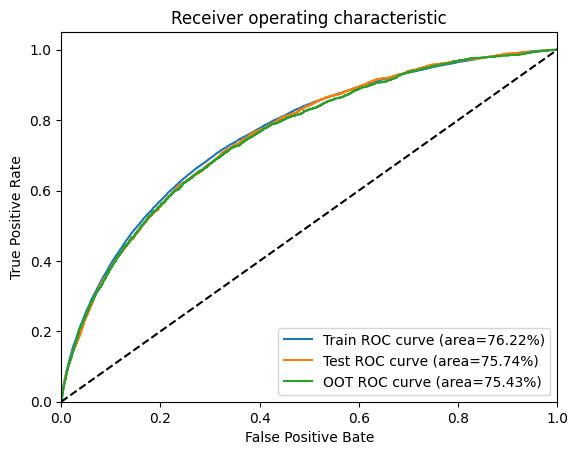

In [ ]:
ROC_curve_combined(y_train,xgb_clf_proba_train[:,1],y_test,xgb_clf_proba_test[:,1],y_oot,xgb_clf_proba_oot[:,1])

### Confusion Matrix

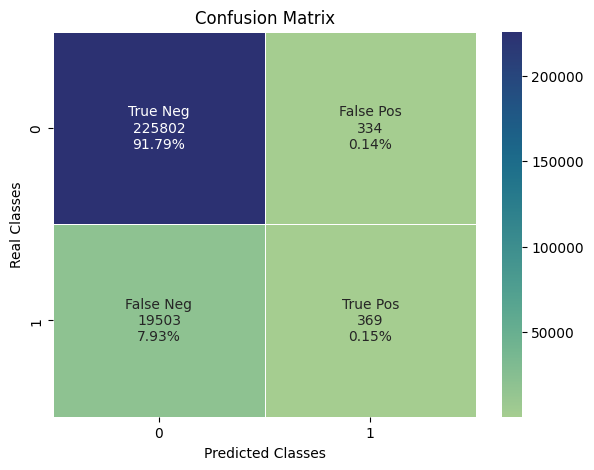

----------------Classification Report----------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226136
           1       0.52      0.02      0.04     19872

    accuracy                           0.92    246008
   macro avg       0.72      0.51      0.50    246008
weighted avg       0.89      0.92      0.88    246008


 ----------------Accuracy, precision, recall, f1_score----------------
Accuracy=0.91936
Precision=0.52489
Recall=0.01857
F1 Score=0.03587


In [ ]:
# Lets plot the confusion matrix
PlotConfusionMatrix(y_train,xgb_clf_predict_train)

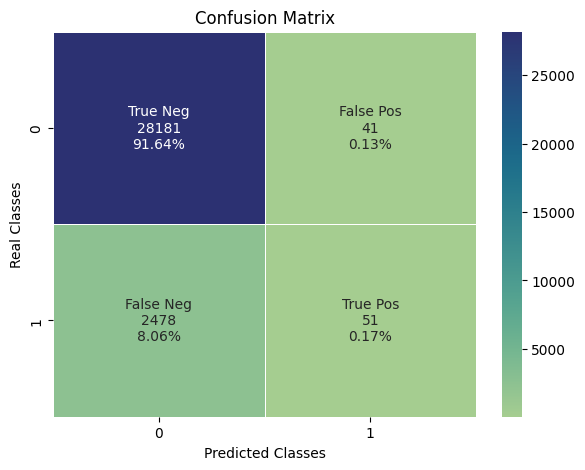

----------------Classification Report----------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28222
           1       0.55      0.02      0.04      2529

    accuracy                           0.92     30751
   macro avg       0.74      0.51      0.50     30751
weighted avg       0.89      0.92      0.88     30751


 ----------------Accuracy, precision, recall, f1_score----------------
Accuracy=0.91808
Precision=0.55435
Recall=0.02017
F1 Score=0.03892


In [ ]:
# Lets plot the confusion matrix
PlotConfusionMatrix(y_test,xgb_clf_predict_test)

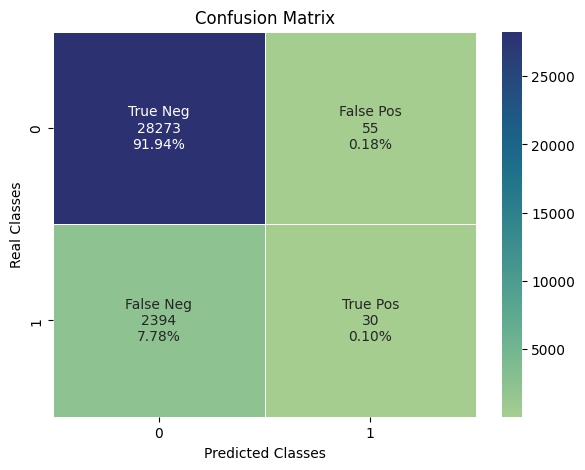

----------------Classification Report----------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28328
           1       0.35      0.01      0.02      2424

    accuracy                           0.92     30752
   macro avg       0.64      0.51      0.49     30752
weighted avg       0.88      0.92      0.88     30752


 ----------------Accuracy, precision, recall, f1_score----------------
Accuracy=0.92036
Precision=0.35294
Recall=0.01238
F1 Score=0.02391


In [ ]:
# Lets plot the confusion matrix
PlotConfusionMatrix(y_oot,xgb_clf_predict_oot)

### Decile Table

In [ ]:
decile_tablel(y_train,xgb_clf_proba_train[:,1],round_decimal=10,change_deciles=10)

,decile,prob_min,prob_max,ttl_customers,bad_customers,gd_customers,cum gd_customers,cum_bad_customers,KS,Lift,FP,cum FP,default_captr%
0,1,0.180892,0.815269,24601.0,6753.0,17848.0,17848.0,6753.0,26.089892,3.398221,2.64,2.64,33.98
1,2,0.120059,0.180891,24601.0,3748.0,20853.0,38701.0,10501.0,35.729159,2.642138,5.56,10.33,52.84
2,3,0.088693,0.120057,24601.0,2601.0,22000.0,60701.0,13102.0,39.089268,2.197714,8.46,23.34,65.93
3,4,0.068453,0.088691,24601.0,1863.0,22738.0,83439.0,14965.0,38.409257,1.882659,12.21,44.79,75.31
4,5,0.053762,0.068453,24600.0,1498.0,23102.0,106541.0,16463.0,35.731526,1.656904,15.42,71.12,82.85
5,6,0.042260,0.053762,24601.0,1085.0,23516.0,130057.0,17548.0,30.792417,1.471751,21.67,119.87,88.31
6,7,0.032901,0.042259,24601.0,890.0,23711.0,153768.0,18438.0,24.785798,1.325480,26.64,172.77,92.78
7,8,0.024737,0.032900,24601.0,653.0,23948.0,177716.0,19091.0,17.481741,1.200869,36.67,272.15,96.07
8,9,0.016966,0.024737,24601.0,505.0,24096.0,201812.0,19596.0,9.367470,1.095675,47.71,399.63,98.61
9,10,0.001914,0.016966,24600.0,276.0,24324.0,226136.0,19872.0,0.000000,1.000000,88.13,819.33,100.00


In [ ]:
decile_tablel(y_test,xgb_clf_proba_test[:,1],round_decimal=10,change_deciles=10)

,decile,prob_min,prob_max,ttl_customers,bad_customers,gd_customers,cum gd_customers,cum_bad_customers,KS,Lift,FP,cum FP,default_captr%
0,1,0.182263,0.731918,3076.0,836.0,2240.0,2240.0,836.0,25.119474,3.304687,2.68,2.68,33.06
1,2,0.122335,0.182201,3075.0,466.0,2609.0,4849.0,1302.0,34.301168,2.573805,5.60,10.41,51.48
2,3,0.089544,0.122325,3075.0,328.0,2747.0,7596.0,1630.0,37.537180,2.148249,8.38,23.16,64.45
3,4,0.069239,0.089543,3075.0,255.0,2820.0,10416.0,1885.0,37.628012,1.863294,11.06,40.85,74.54
4,5,0.054216,0.069226,3075.0,188.0,2887.0,13303.0,2073.0,34.832172,1.639330,15.36,70.76,81.97
5,6,0.042257,0.054209,3075.0,158.0,2917.0,16220.0,2231.0,30.743793,1.470246,18.46,102.66,88.22
6,7,0.032936,0.042251,3075.0,118.0,2957.0,19177.0,2349.0,24.932027,1.326875,25.06,162.52,92.88
7,8,0.024646,0.032935,3075.0,92.0,2983.0,22160.0,2441.0,18.000060,1.206495,32.42,240.87,96.52
8,9,0.017014,0.024641,3075.0,55.0,3020.0,25180.0,2496.0,9.473961,1.096609,54.91,457.82,98.70
9,10,0.002073,0.017013,3075.0,33.0,3042.0,28222.0,2529.0,0.000000,1.000000,92.18,855.21,100.00


In [ ]:
decile_tablel(y_oot,xgb_clf_proba_oot[:,1],round_decimal=10,change_deciles=10)

,decile,prob_min,prob_max,ttl_customers,bad_customers,gd_customers,cum gd_customers,cum_bad_customers,KS,Lift,FP,cum FP,default_captr%
0,1,0.179223,0.742314,3076.0,799.0,2277.0,2277.0,799.0,24.924063,3.295347,2.85,2.85,32.96
1,2,0.120922,0.179214,3075.0,459.0,2616.0,4893.0,1258.0,34.625027,2.594631,5.70,10.66,51.90
2,3,0.088874,0.120912,3075.0,308.0,2767.0,7660.0,1566.0,37.563576,2.153372,8.98,24.87,64.60
3,4,0.068215,0.088867,3075.0,234.0,2841.0,10501.0,1800.0,37.188095,1.856405,12.14,44.88,74.26
4,5,0.053940,0.068214,3075.0,175.0,2900.0,13401.0,1975.0,34.170346,1.629538,16.57,76.58,81.48
5,6,0.042560,0.053938,3076.0,139.0,2937.0,16338.0,2114.0,29.536835,1.453457,21.13,117.54,87.21
6,7,0.032767,0.042555,3075.0,132.0,2943.0,19281.0,2246.0,24.593366,1.323631,22.30,146.07,92.66
7,8,0.024514,0.032767,3075.0,88.0,2987.0,22268.0,2334.0,17.679391,1.203570,33.94,253.05,96.29
8,9,0.016721,0.024512,3075.0,49.0,3026.0,25294.0,2383.0,9.018832,1.092310,61.76,516.20,98.31
9,10,0.002669,0.016719,3075.0,41.0,3034.0,28328.0,2424.0,0.000000,1.000000,74.00,690.93,100.00


### Observations and Conclusion:
1. ROC AUC of 75.43% is achieved on the OOT data.
2. At 20% of the total transactions this model was able to capture around 51.9% of total defaulters.

## Predictions on the Kaggle Test dataset:

In [ ]:
# Merged Application test dataframe
pickle_in=open(pickle_path+"application_test_merged.pickle","rb")
application_test_merged=pickle.load(pickle_in)
pickle_in.close()
print("Shape of featurized Application test merged dataframe is",application_test_merged.shape)

Shape of featurized Application test merged dataframe is (48744, 1771)


In [ ]:
# Prediction on the application_test_merged dataframe
xgb_clf_proba_test_oot=xgb_clf.predict_proba(X_test_oot)

In [ ]:
# Preparing the dataframe to be submitted at Kaggle Submission
XGB_sol_kaggle=pd.DataFrame(application_test_merged['SK_ID_CURR'])
XGB_sol_kaggle['TARGET'] = pd.Series(xgb_clf_proba_test_oot[:,1])
XGB_sol_kaggle

,SK_ID_CURR,TARGET
0,100001,0.048199
1,100005,0.084374
2,100013,0.036691
3,100028,0.028586
4,100038,0.181008
...,...,...
48739,456221,0.024039
48740,456222,0.093635
48741,456223,0.029465
48742,456224,0.054996


In [ ]:
# Lets save a dataframe as csv and upload the results on the kaggle submission
XGB_sol_kaggle.to_csv('/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/XGB_sol_kaggle.csv',index=False)

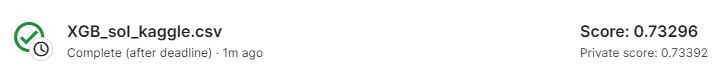

In [ ]:
Image(filename='/content/drive/MyDrive/Career/DS/Case Studies/Home Credit Default Risk/XgbKaggleResult.JPG',width=800,height=100)

### Observations about the kaggle solution submission:
ROC AUC of 73.29% is achieved on the kaggle test data for this model.